# Detección de enfermedades cardíacas con Machine Learning
Grupo 1 - Tarea Académica - Inteligencia Artificial

Integrantes:
- Daysi Campos Fernández
- Josué Altamirano Mendiola
- Joshua Haro Capcha
- Bryan Smith Valdiviezo Jiménez
- Kevin Diaz Mendieta


In [ ]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install skrebate

from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, balanced_accuracy_score  # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard
from skrebate import ReliefF
from typing import Any
import warnings
warnings.filterwarnings("ignore")

Cargar dataset de **Cardiovascular_Disease_Dataset.csv**

In [ ]:
dataset = pd.read_csv('Cardiovascular_Disease_Dataset.csv', index_col = 0, sep = ',')

# separa el dataset en atributos (X)  y  target (y)
x = dataset.drop(columns=['target'])
y = dataset['target']

# realiza el train-test split
vadid_fraction = 0.25
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=vadid_fraction, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_test)))

Training: 750 ejemplos. Validation: 250 ejemplos


In [ ]:
dataset.head()

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
patientid,,,,,,,,,,,,,
103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [ ]:
dataset['target'].value_counts()

,count
target,
1,580
0,420


**No se considera desbalance significativo, ya que ninguna clase tiene entre el 60%-80% de las instancias del conjunto de datos.**


### Evalua diferentes algoritmos de ML en crossvalidacion

Vamos a evaluar los algoritmos de ML clásicos y compararlo con diferentes algoritmos de ensamble:

    - Logistic Regression
    - K-Nearest Neighbors
    - Classification and Regression Trees
    - Random Forest
    - Ada Boost
    - XGBoost

In [ ]:
# Configuración de los modelos
models: dict[str, Any] = {}
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=seed),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, random_state=seed),
    "Random Forest": RandomForestClassifier(
          n_estimators=100,        # Número de árboles
          max_depth=8,            # Profundidad máxima de los árboles
          random_state=seed        # Asegurar reproducibilidad
      ),
    "AdaBoost": AdaBoostClassifier(n_estimators=60 , random_state=seed),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=seed)
}

La evaluacion de cada algoritmo se realiza con los datos de training en estrategia de Crossvalidacion con 10-folds. Se usa el mismo particionamiento de folds en cada algoritmo a evaluar para asegurar una comparación justa.


Las métricas de evaluacion son

In [ ]:
# Configuración de validación cruzada
kfold = 10
scorer = make_scorer(f1_score, average='weighted')  # Usar F1-Score ponderado

# Evaluar los modelos
final_cv_results = []
final_cv_names = []

for model_name, model in models.items():
    pipeline = make_pipeline(MinMaxScaler(), model)
    try:
        scores = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring=scorer)
        final_cv_results.append(scores)
        final_cv_names.append(model_name)
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")

# Resumir los resultados
final_cv_summary = pd.DataFrame({
    "Model": final_cv_names,
    "Mean F1-Score": [scores.mean() for scores in final_cv_results],
    "Std Deviation": [scores.std() for scores in final_cv_results]
})

print(final_cv_summary)

                 Model  Mean F1-Score  Std Deviation
0  Logistic Regression       0.956033       0.020589
1  K-Nearest Neighbors       0.917345       0.031898
2        Decision Tree       0.966663       0.022515
3        Random Forest       0.975894       0.018831
4             AdaBoost       0.973313       0.017921
5              XGBoost       0.969244       0.020806


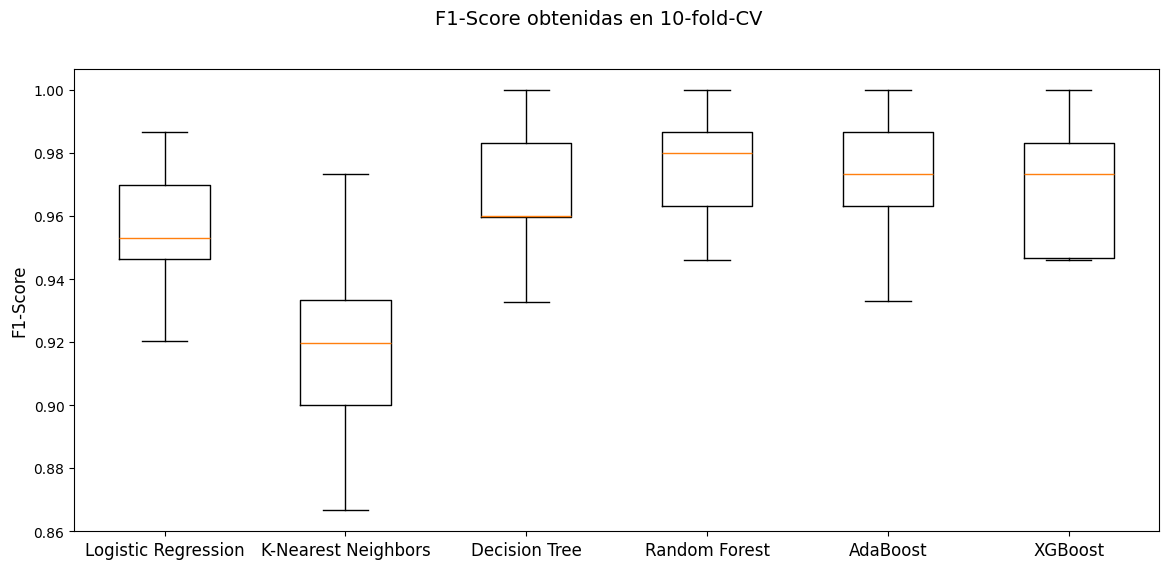

In [ ]:
# Configurar el tamaño del gráfico
fig = plt.figure(figsize=(14, 6))  # Cambia los valores para ajustar el tamaño
fig.suptitle('F1-Score obtenidas en 10-fold-CV', fontsize=14)

# Agregar el gráfico
ax = fig.add_subplot(111)
plt.boxplot(final_cv_results)

# Etiquetas de los ejes
ax.set_xticklabels(final_cv_names, fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)

# Mostrar el gráfico
plt.show()

### Entrena el  modelo con el algoritmo seleccionado y lo prueba en datos de validacion

Ahora entrenaremos un modelo con el mejor algoritmo RandomForestClassifier(class_weight='balanced', random_state=seed)
 usando todos los datos de entrenamiento y lo evaluamos en la data separada para validacion

In [ ]:
best_model = RandomForestClassifier(class_weight='balanced', random_state=seed)
best_model.fit(x_train, y_train)

# Predecir la clase del conjunto de prueba (simula la validación final)
y_predicted = best_model.predict(x_test)

# Calcular y mostrar el F1-Score
print("F1-score:", f1_score(y_test, y_predicted))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# Mostrar el reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación en conjunto de prueba: \n")
print(classification_report(y_test, y_predicted))

F1-score: 0.9891696750902527

Matriz de Confusión:
[[110   2]
 [  1 137]]

Reporte de clasificación en conjunto de prueba: 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       112
           1       0.99      0.99      0.99       138

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



### Cargar los modelos

Se cargan y configuran todos los modelos previamente definidos, permitiendo llevar a cabo un análisis  para la selección de los atributos más relevantes en función del desempeño de cada uno de ellos.


In [ ]:
# Configuración de los modelos
models: dict[str, Any] = {}
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=seed),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, random_state=seed),
    "Random Forest": RandomForestClassifier(
          n_estimators=100,        # Número de árboles
          max_depth=8,            # Profundidad máxima de los árboles
          random_state=seed        # Asegurar reproducibilidad
      ),
    "AdaBoost": AdaBoostClassifier(n_estimators=60 , random_state=seed),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=seed)
}

#Selección de atributos

In [ ]:
# Obtener las puntuaciones de relevancia para cada atributo
relief = ReliefF(n_neighbors=30)
relief.fit(x_train.values, y_train.values)
feature_scores = pd.DataFrame({
    'Feature': x_train.columns,
    'Score': relief.feature_importances_
}).sort_values(by='Score', ascending=False)

print(feature_scores)

              Feature     Score
10              slope  0.592089
3           restingBP  0.241917
11   noofmajorvessels  0.238267
2           chestpain  0.229467
4     serumcholestrol  0.098540
6     restingrelectro  0.084800
5   fastingbloodsugar  0.055422
7        maxheartrate  0.044122
9             oldpeak  0.042497
1              gender  0.025867
0                 age  0.006559
8       exerciseangia -0.035111


Ahora obtendremos el número óptimo de atributos evaluando cada algorimo debido a la imporntacia de cada atributo

In [ ]:
# Configuración de validación cruzada y métrica
kfold = 10  # Número de particiones
scorer = make_scorer(f1_score, average='weighted')  # Usar F1-Score ponderado

# Rango de características a evaluar
features_to_test = list(range(4, 13))  # Probar entre 4 y 12 características
results_per_feature = {k: [] for k in features_to_test}  # Resultados por cantidad de características

# Evaluar diferentes cantidades de características para todos los modelos
for k in features_to_test:
    # Seleccionar las k características más importantes según ReliefF
    selected_features = feature_scores['Feature'][:k].tolist()

    for model_name, model in models.items():
        pipeline = make_pipeline(MinMaxScaler(), model)  # Crear pipeline con escalado
        try:
            # Validación cruzada
            scores = cross_val_score(pipeline, x_train[selected_features], y_train, cv=kfold, scoring=scorer)
            f1_mean = scores.mean()  # F1-Score promedio
            results_per_feature[k].append(f1_mean)  # Guardar resultados
        except Exception as e:
            print(f"Error with model {model_name} and {k} features: {e}")
            results_per_feature[k].append(0)  # Penalizar errores con 0

# Calcular el F1-Score promedio para cada cantidad de características
average_f1_scores = {k: np.mean(scores) for k, scores in results_per_feature.items()}

# Determinar la cantidad óptima de características
optimal_features_count = max(average_f1_scores, key=average_f1_scores.get)
print(f"Número óptimo de características: {optimal_features_count}")

# Seleccionar las características óptimas
optimal_features = feature_scores['Feature'][:optimal_features_count].tolist()
print(f"Características seleccionadas: {optimal_features}")

Número óptimo de características: 10
Características seleccionadas: ['slope', 'restingBP', 'noofmajorvessels', 'chestpain', 'serumcholestrol', 'restingrelectro', 'fastingbloodsugar', 'maxheartrate', 'oldpeak', 'gender']


#Agregamos el atributo de Age
Inicialmente se seleccionaron los 10 atributos más significativos, pero se incluyó la edad debido a su destacada importancia en la predicción de enfermedades cardiovasculares, respaldada por libros y guías médicas (Ghosh et al., 2021).

In [ ]:
# Configuración de validación cruzada y métrica
kfold = 10  # Número de particiones
scorer = make_scorer(f1_score, average='weighted')  # Usar F1-Score ponderado

# Rango de características a evaluar
features_to_test = list(range(4, 13))  # Probar entre 4 y 12 características
results_per_feature = {k: [] for k in features_to_test}  # Resultados por cantidad de características

# Evaluar diferentes cantidades de características para todos los modelos
for k in features_to_test:
    # Seleccionar las k características más importantes según ReliefF
    selected_features = feature_scores['Feature'][:k].tolist()
    if "age" not in selected_features:
            selected_features[-1] = "age"  # Asegurar que "age" esté incluida

    for model_name, model in models.items():
        pipeline = make_pipeline(MinMaxScaler(), model)  # Crear pipeline con escalado
        try:
            # Validación cruzada
            scores = cross_val_score(pipeline, x_train[selected_features], y_train, cv=kfold, scoring=scorer)
            f1_mean = scores.mean()  # F1-Score promedio
            results_per_feature[k].append(f1_mean)  # Guardar resultados
        except Exception as e:
            print(f"Error with model {model_name} and {k} features: {e}")
            results_per_feature[k].append(0)  # Penalizar errores con 0

# Calcular el F1-Score promedio para cada cantidad de características
average_f1_scores = {k: np.mean(scores) for k, scores in results_per_feature.items()}

# Determinar la cantidad óptima de características
optimal_features_count = max(average_f1_scores, key=average_f1_scores.get)
print(f"Número óptimo de características: {optimal_features_count}")

# Seleccionar las características óptimas
optimal_features = feature_scores['Feature'][:optimal_features_count].tolist()
print(f"Características seleccionadas: {optimal_features}")

Número óptimo de características: 11
Características seleccionadas: ['slope', 'restingBP', 'noofmajorvessels', 'chestpain', 'serumcholestrol', 'restingrelectro', 'fastingbloodsugar', 'maxheartrate', 'oldpeak', 'gender', 'age']


En base a los resultados obtenidos, la cantidad de características que maximizan la métrica de F1-Score en promedio es 11.

#Evaluación de los modelos según las características seleccionadas
Se evaluarán los modelos utilizando las características seleccionadas que obtuvieron los mejores resultados durante el proceso de selección. Posteriormente, se analizarán sus métricas para comparar el desempeño de cada modelo.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

optimal_features = feature_scores['Feature'][:optimal_features_count].tolist()
# Filtrar las características en ambos conjuntos
X_train_selected = x_train[optimal_features]
X_test_selected = x_test[optimal_features]

# Entrenar y evaluar cada modelo
model_results = {}

for model_name, model in models.items():
    pipeline = make_pipeline(MinMaxScaler(), model)  # Crear pipeline con escalado
    pipeline.fit(X_train_selected, y_train)  # Entrenar el modelo
    y_pred = pipeline.predict(X_test_selected)  # Predicciones

    # Calcular métricas
    f1_metric = f1_score(y_test, y_pred, average='weighted')
    accuracy_metric = accuracy_score(y_test, y_pred)
    recall_metric = recall_score(y_test, y_pred, average='weighted')
    precision_metric = precision_score(y_test, y_pred, average='weighted')

    # Guardar resultados
    model_results[model_name] = {
        'F1-Score': f1_metric,
        'Accuracy': accuracy_metric,
        'Recall': recall_metric,
        'Precision': precision_metric
    }

# Mostrar resultados finales
print("Resultados por modelo:")
for model_name, metrics in model_results.items():
    print(f"{model_name}:")
    print(f"  F1-Score: {metrics['F1-Score']:.4f}")

# Determinar el mejor modelo basado en F1-Score
best_model = max(model_results, key=lambda k: model_results[k]['F1-Score'])
print(f"\nEl mejor modelo basado en F1-Score es: {best_model}")

Resultados por modelo:
Logistic Regression:
  F1-Score: 0.9680
K-Nearest Neighbors:
  F1-Score: 0.9359
Decision Tree:
  F1-Score: 0.9680
Random Forest:
  F1-Score: 0.9920
AdaBoost:
  F1-Score: 0.9760
XGBoost:
  F1-Score: 0.9680

El mejor modelo basado en F1-Score es: Random Forest


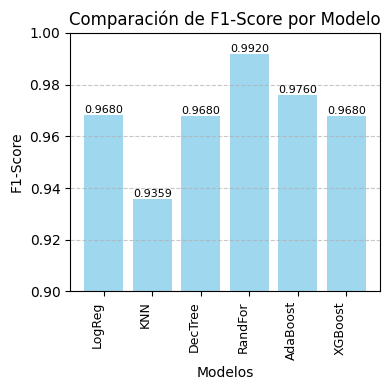

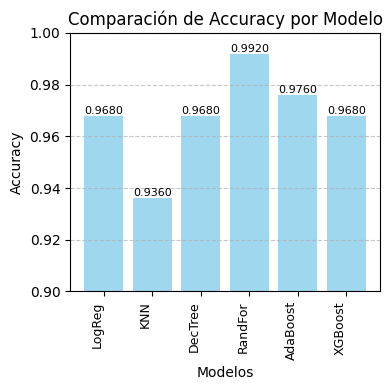

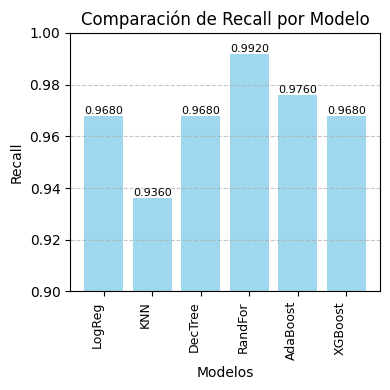

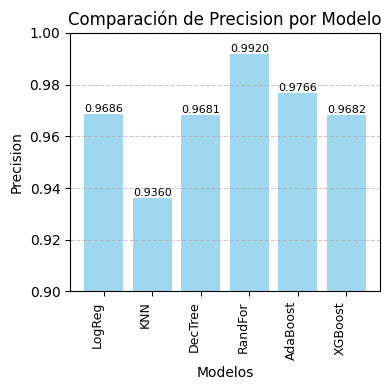

In [ ]:
import matplotlib.pyplot as plt

# Diccionario para renombrar los modelos
short_names = {
    "Logistic Regression": "LogReg",
    "K-Nearest Neighbors": "KNN",
    "Decision Tree": "DecTree",
    "Random Forest": "RandFor",
    "AdaBoost": "AdaBoost",
    "XGBoost": "XGBoost"
}

# Iterar sobre las métricas en el diccionario y graficar
for metric in ["F1-Score", "Accuracy", "Recall", "Precision"]:
    # Extraer los valores de la métrica actual para todos los modelos
    values = [model_results[model][metric] for model in model_results.keys()]
    model_names = [short_names[model] for model in model_results.keys()]  # Usar nombres cortos

    # Crear el gráfico
    plt.figure(figsize=(4, 4))
    bars = plt.bar(model_names, values, color='skyblue', alpha=0.8)

    # Agregar etiquetas con los valores exactos
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}",
                 ha='center', va='bottom', fontsize=8)

    # Configuración del gráfico
    plt.title(f"Comparación de {metric} por Modelo", fontsize=12)
    plt.xlabel("Modelos", fontsize=10)
    plt.ylabel(metric, fontsize=10)
    plt.ylim(0.9, 1.0)  # Ajustar el rango de la gráfica
    plt.xticks(rotation=90, ha='right', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()